
## Final Project: LinkedIn Job Posting - Data Mining and Analysis


## Objective:

### ***Purpose of this project is to scrape LinkedIn Job Portal to extract jobs posted in the data industry and understand the most required skills for these Job Titles***

## Part 1: Scraping Jobs From LinkedIn

In [250]:
# Import Required Libraries
import pandas as pd
import re
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support import expected_conditions as EC

In [256]:
# Install the latest available version of chromedriver automatically, 
# as the versions seems to expire frequently throwing an error
browser = webdriver.Chrome(ChromeDriverManager().install())

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 96.0.4664
[WDM] - Get LATEST driver version for 96.0.4664
[WDM] - Driver [C:\Users\User\.wdm\drivers\chromedriver\win32\96.0.4664.45\chromedriver.exe] found in cache


In [257]:
# Open the LinkedIn Website in the ChromeBrowser above
browser.get("https://linkedin.com")

In [258]:
# Input user email id and password to login for better results, 
# the input information has been masked after execution for privacy
username = browser.find_element_by_id("session_key")
username.send_keys("******")
password = browser.find_element_by_id("session_password")
password.send_keys("*******")
password.send_keys(Keys.ENTER)

In [259]:
# The list of job title we have targetted for our analysis
searchList = ['Data Analyst', 'Data Scientist', 
              'Data Engineer', 'Machine Learning Engineer',
              'Database Administrator', 'Data Architect', 'Business Analyst']

In [260]:
# Goto LinkedIn job page and enter the Key word and location for searching relevant jobs
browser.get("https://linkedin.com/jobs/")

job_title = "Business Analyst"
country = "Canada"

search_title = browser.find_element_by_xpath("//input[starts-with(@id, 'jobs-search-box-keyword')]")
search_title.send_keys(job_title)
search_country = browser.find_element_by_xpath("//input[starts-with(@id, 'jobs-search-box-location')]")
search_country.send_keys(country)
time.sleep(2)
search_button = browser.find_element_by_css_selector('button.jobs-search-box__submit-button')
search_button.click()

In [264]:
# Extract jobs from each job card container in the website and extract below fields in the data

search_title = []
job_title = []
company_list = []
job_location = []
job_description = []
job_type = []


for pg_no in range(1,41):

    try:
        page = browser.find_element_by_css_selector("[aria-label='Page {}']".format(pg_no))
        page.click()

        
        all_listings = browser.find_elements_by_css_selector(".job-card-container--clickable")
        time.sleep(1)

        for listing in all_listings:
            time.sleep(2)
            listing.click()
            time.sleep(1)
            job_view = browser.find_elements_by_class_name('job-view-layout')
            for desc in job_view:
                title = desc.find_element_by_tag_name('h2').get_attribute('innerText')
                job_title.append(title)
                company = desc.find_element_by_class_name('jobs-unified-top-card__subtitle-primary-grouping').get_attribute('innerText')
                company_list.append(company)
                location = desc.find_element_by_class_name('jobs-unified-top-card__bullet').get_attribute('innerText')
                job_location.append(location)
                job_desc = desc.find_element_by_class_name('jobs-description').get_attribute('innerText')
                job_description.append(job_desc)
                search_title.append("Data Analyst")
                job_type_name = desc.find_element_by_class_name('flex-shrink-zero').get_attribute('innerText')
                job_type.append(job_type_name)
            
    except:
#         browser.refresh()
        refresh_button = browser.find_element_by_css_selector('jobs-search-no-results__reload')
        refresh_button.click()
        time.sleep(2)
        print("Stopped extract at Page {}, Retrying...".format(pg_no))
            

In [265]:
# Store all the extracted fields which are in the form of list to dataframe for easy processing
myJobs = pd.DataFrame(
    {'Search Title': search_title,
     'Job Title': job_title,
     'Company': company_list,
     'Location': job_location,
     'Job Description': job_description,
     'Job Type':job_type
    })


In [267]:
# Append the extracted data into a final dataframe
# finalDf = pd.DataFrame()
finalDf = finalDf.append(myJobs)

**In this piece of code I have only demonstrated extracting jobs for business analyst, for the project we repeated the running of last 2 cells to extract jobs for all the items in our search list.**

In [268]:
# Dropping duplicates in case same job has popped up for several search keys.
finalDf = finalDf.drop_duplicates()

In [269]:
# Store the extracted data into a CSV file for ease of further processing and to avoid multiple extraction from LinkedIn
myJobs.to_csv("MyJobs_All.csv")

## Part 2: Process LinkedIn data and build a model

In [270]:
# Import Libraries

import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
stopwordsEng = stopwords.words('English')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from nltk import PorterStemmer

from nltk.stem import WordNetLemmatizer

from nltk.util import bigrams, trigrams, ngrams

import matplotlib.pyplot as plt
import seaborn as sns

In [271]:
# Read the previously extracted data from LinkedIn
df = pd.read_csv("MyJobs_All.csv")

In [272]:
# View the sample data
df.head(2)

,Unnamed: 0,Search Title,Job Title,Company,Location,Job Description,Job Type
0,0,Data Analyst,Data Quality Analyst,"Mackenzie Health Vaughan, ON On-site","Vaughan, ON",Posted by\n\nMelany Shapiro\n\n--\n\nSend InMa...,NaN
1,1,Data Analyst,"Sr. Data Marketing Analyst, Enterprise Analyti...","JLL Technologies Toronto, ON","Toronto, ON",About JLL –\n\nWe’re JLL—a leading professiona...,NaN


In [273]:
# View the shape of the dataset
df.shape

(1234, 7)

In [275]:
# Look for missing values in the data for removal of columns
df.isnull().mean()*100

Unnamed: 0           0.0
Search Title         0.0
Job Title            0.0
Company              0.0
Location             0.0
Job Description      0.0
Job Type           100.0
dtype: float64

In [276]:
# Drop Unwanted columns
df = df.drop(columns = ['Unnamed: 0', 'Job Type'])

In [277]:
# View a sample of 2 records
df.sample(2)

,Search Title,Job Title,Company,Location,Job Description
265,Data Engineer,Data Engineer (Temporary Fulltime - 10 months),ICBC (Insurance Corporation of British Columbi...,"North Vancouver, BC","At ICBC, it’s our job to make sure the car ins..."
712,Database Administrator,ServiceNow Developer,"AutoCanada Edmonton, AB","Edmonton, AB",At AutoCanada we are passionate about our busi...


In [278]:
# Get the list of unique title we search for in LinkedIn
df['Search Title'].unique()

array(['Data Analyst', 'Data Scientist', 'Data Engineer',
       'Machine Learning Engineer', 'Database Administrator',
       'Data Architect', 'Business Analyst'], dtype=object)

In [279]:
# Group by search title to identify the number of jobs we extracted in each search
jobs_per_role = df.groupby(by=['Search Title']).aggregate({"Search Title":"count"})
jobs_per_role = jobs_per_role.rename(columns = {"Search Title":"Job_Count"})
jobs_per_role = jobs_per_role.reset_index()
jobs_per_role

,Search Title,Job_Count
0,Business Analyst,227
1,Data Analyst,151
2,Data Architect,168
3,Data Engineer,151
4,Data Scientist,102
5,Database Administrator,281
6,Machine Learning Engineer,154


In [287]:
# Set the Palette for Visualization
sns.set_palette("pastel")

Text(0.5, 0, 'Job Title')

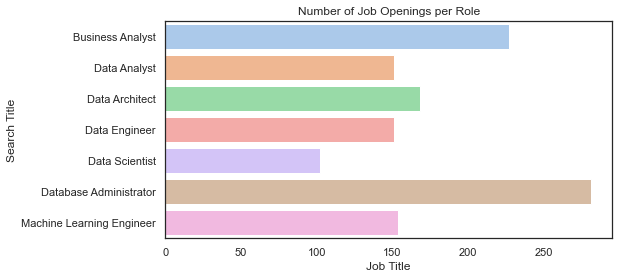

In [288]:
# Visualize the number of jobs available for each search title
plt.figure(figsize = (8,4))
sns.barplot(y="Search Title", x="Job_Count", data = jobs_per_role)
plt.title("Number of Job Openings per Role")
plt.xlabel("No of Jobs")
plt.xlabel("Job Title")

In [289]:
# View the different Job Title extracted, irrespective of the title searched for
df['Job Title'].value_counts()

Data Engineer                                                 48
Senior Data Engineer                                          44
Business Analyst                                              33
Analyste programmeur                                          26
Data Scientist                                                24
                                                              ..
Senior Software Engineer - Analytics                           1
Pension document programmer                                    1
Senior Software Engineer, Data Connections (Vancouver, BC)     1
Technical Business Analyst, Identity & Access Management       1
Data Scientist II (Training)                                   1
Name: Job Title, Length: 758, dtype: int64

In [290]:
# We have 758 Unique Job Titles eventhough we have only 7 in our search list
print("The total number of unique Job titles in our sample is:",len(list(df['Job Title'].unique())))

The total number of unique Job titles in our sample is: 758


In [291]:
# Get the most popular Job roles from our data extract
job_titles = df.groupby(by=['Job Title']).aggregate({"Job Title":"count"})
job_titles = job_titles.rename(columns = {"Job Title":"Job_Count"})
job_titles = job_titles.reset_index()
job_titles = job_titles.sort_values(by='Job_Count', ascending = False)
top15 = job_titles.head(15)
top15

,Job Title,Job_Count
195,Data Engineer,48
536,Senior Data Engineer,44
65,Business Analyst,33
30,Analyste programmeur,26
240,Data Scientist,24
522,Senior Data Analyst,17
398,Machine Learning Engineer,16
183,Data Architect,14
628,ServiceNow Developer,13
163,Data Analyst,13


Text(0.5, 0, 'Job Title')

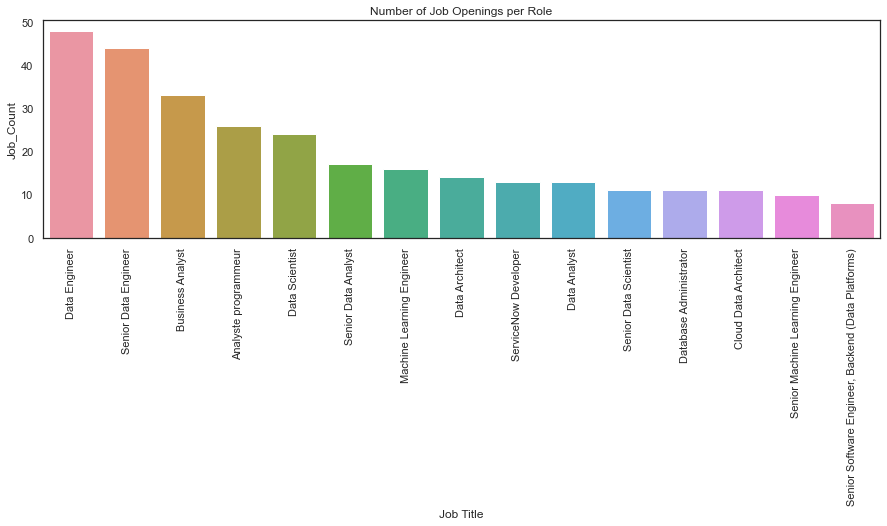

In [295]:
# Visualize the number of jobs available for each search title
plt.figure(figsize = (15,4))
sns.barplot(x="Job Title", y="Job_Count", data = top15)
plt.title("Number of Job Openings per Role")
plt.xticks(rotation = 90)
plt.xlabel("No of Jobs")
plt.xlabel("Job Title")

In [365]:
# Get the 20 most popular cities for Jobs in Canada
Locs = df['Location'].value_counts()[0:20]
Locs = Locs.to_frame().reset_index()
Locs.columns = ['City','Count']
top20 = Locs['City'].unique()

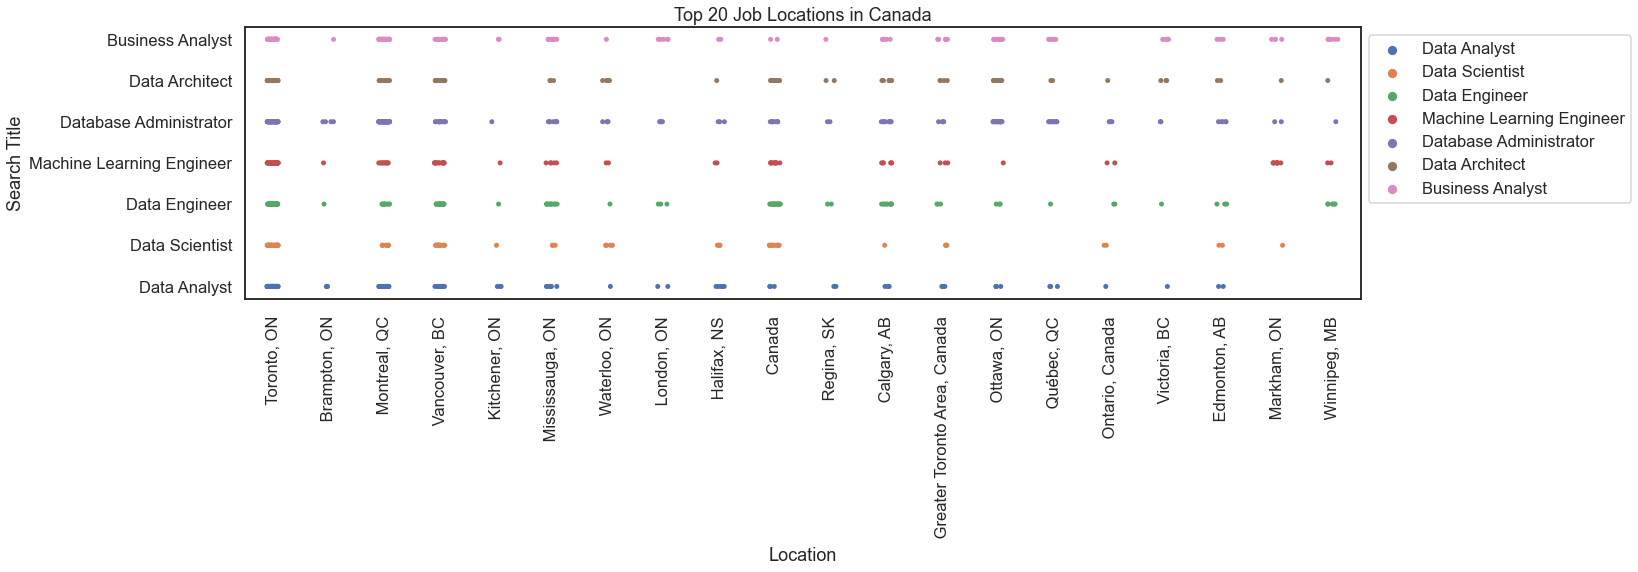

In [367]:
# Visualize the 20 most popular cities for Jobs in Canada
plt.figure(figsize = (20,5))
sns.set_style("white") 
sns.stripplot(x='Location', y='Search Title', data=df[df['Location'].isin(top20)], palette = "deep", hue='Search Title')
plt.xticks(rotation = 90)
plt.title("Top 20 Job Locations in Canada")
plt.legend(bbox_to_anchor=(1, 1))

## 2. Data Preparation

### a. Remove Location from company name

In [331]:
# The way the Jobtitle variable is designed in the LinkedIn portal we are only able to capture the company name
# Along with the Location of Job, hence remove this from the Company Name using re
for i in range(len(df['Company'])):
    df['Company'][i] = re.sub(df['Location'][i], '', df['Company'][i])

In [332]:
df.sample(2)

,Search Title,Job Title,Company,Location,Job Description
455,Machine Learning Engineer,Sr. Machine Learning Engineer - Health ML,Twitter,Canada,\n\nThe Health ML engineering team is responsi...
354,Data Engineer,Data Engineer,Invenia Labs,"Winnipeg, MB",Posted by\n\nRobbie Smith\n\nTalent Specialist...


### b. Extract Information from Job Description Column

In [333]:
# Convert to lower and tokenize

df['Job Description1'] = df['Job Description'].apply(lambda x: word_tokenize(x.lower()))

In [406]:
df['Job Description2'] = df['Job Description'].apply(lambda x: sent_tokenize(x.lower())) 

In [335]:
def extract_years(text):
    res = re.search('year', text)
    if res == None:
        yr_text = "0 years"
        yr_num = 0
        
    else:   
        index = res.start()
        yr_text = text[index - 6 : index + 6]
        yr_num = (re.findall('[0-9]',yr_text))
    
    
    return yr_text

In [336]:
# df["Years"] = df["Job Description"].apply(lambda x: re.search('year', x))
df["Years"] = df["Job Description"].apply(lambda x: extract_years(x))

In [337]:
df.head(2)

,Search Title,Job Title,Company,Location,Job Description,Job Description1,Job Description2,Years
0,Data Analyst,Data Quality Analyst,Mackenzie Health On-site,"Vaughan, ON",Posted by\n\nMelany Shapiro\n\n--\n\nSend InMa...,"[posted, by, melany, shapiro, --, send, inmail...",[posted by\n\nmelany shapiro\n\n--\n\nsend inm...,ast 3 years
1,Data Analyst,"Sr. Data Marketing Analyst, Enterprise Analyti...",JLL Technologies,"Toronto, ON",About JLL –\n\nWe’re JLL—a leading professiona...,"[about, jll, –, we, ’, re, jll—a, leading, pro...",[about jll –\n\nwe’re jll—a leading profession...,3 - 5 years


In [341]:
#Functions to extract numbers and identify the minimum and maximum years of experience requirement 

def ext_min_year(text):
    yr_list = re.findall('[0-9]', text)
    
    if len(yr_list) == 0:
        min_year = 0
    elif len(yr_list) == 1:
        min_year = 0
    else:
        min_year = yr_list[1]
    
    return min_year

def ext_max_year(text):
    yr_list = re.findall('[0-9]', text)
    
    if len(yr_list) == 0:
        max_year = 0
    elif len(yr_list) == 1:
        max_year = yr_list[0]
    else:
        max_year = yr_list[1]
    
    return max_year

df["Min_Years"] = df["Years"].apply(lambda x: ext_min_year(x))
df["Max_Years"] = df["Years"].apply(lambda x: ext_max_year(x))

In [343]:
# Extract the first name of the company
df['Company_Split'] = df['Company'].apply(lambda x: x.lower().split())
df['Company_first_name'] = df['Company_Split'].apply(lambda x: x[0] if len(x) > 0 else x)


In [369]:
# Convert columns into required data types for further visualization
df['Company_name'] = df['Company_first_name'].apply(lambda x: str(x))
df['Min_Years'] = df['Min_Years'].apply(lambda x: int(x))
df['Max_Years'] = df['Max_Years'].apply(lambda x: int(x))

In [371]:
# Get the top Companies hiring for specific roles
ComName = df.groupby(by=['Company_name','Search Title']).agg({'Company_name':'count'})
ComName = ComName.rename(columns = {"Company_name":"JobCount"})
ComName = ComName.reset_index()
ComName = ComName.sort_values(by='JobCount', ascending = False)
ComName = ComName.reset_index(drop=True)
top20names = ComName.head(20)
top20names['Company_name'] = top20names['Company_name'].apply(lambda x: x.upper())
top20names

C:\Users\User\AppData\Local\Temp/ipykernel_16780/3786437096.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top20names['Company_name'] = top20names['Company_name'].apply(lambda x: x.upper())


,Company_name,Search Title,JobCount
0,MERITEK,Database Administrator,22
1,PYTHIAN,Database Administrator,10
2,Q²,Data Analyst,9
3,DELOITTE,Data Architect,9
4,CGI,Database Administrator,9
5,TWITTER,Machine Learning Engineer,9
6,AMAZON,Data Architect,8
7,TRUPANION,Data Engineer,8
8,SLALOM,Data Architect,8
9,AVANADE,Business Analyst,8


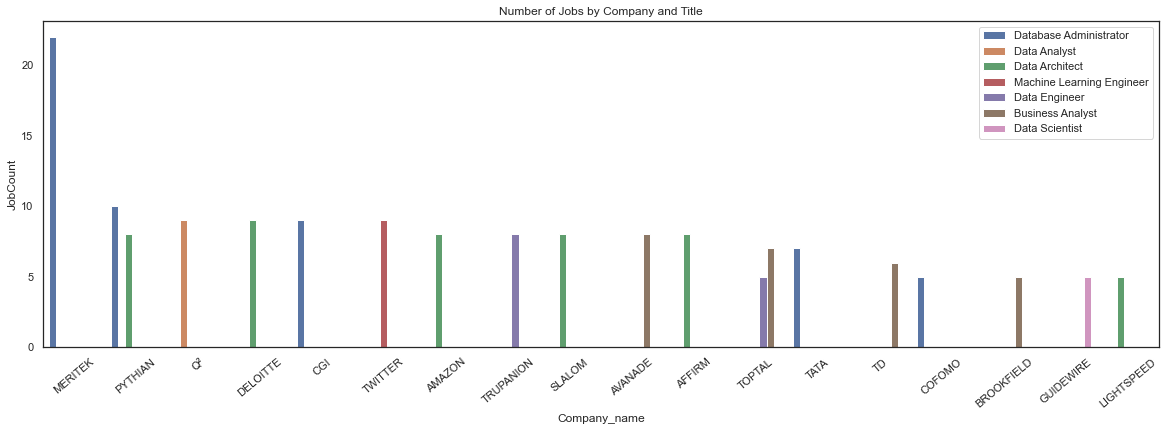

In [375]:
sns.set(rc={'figure.figsize':(20,6)})
sns.set_style("white") 
sns.barplot(x='Company_name',y='JobCount', hue='Search Title', data = top20names )
plt.xticks(rotation = 40)
plt.title("Number of Jobs by Company and Title")
plt.legend(loc=1)

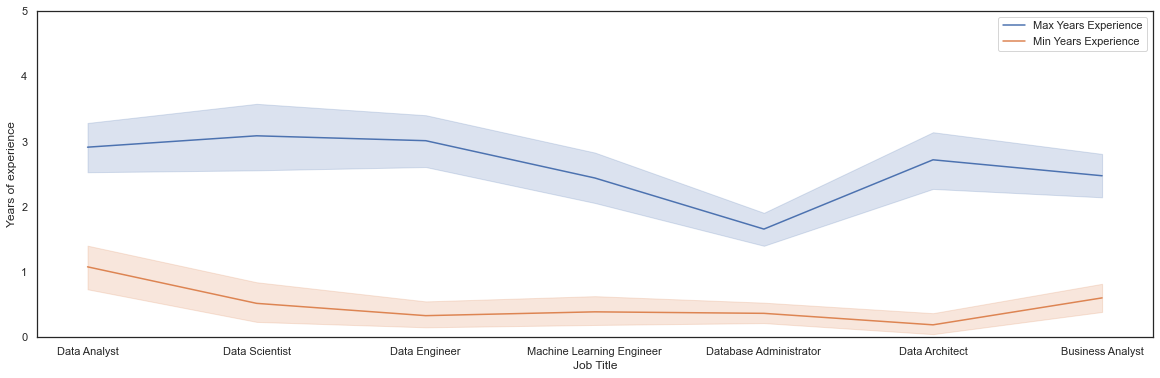

In [377]:
# Visualize the average number of minumum and maximum years of experience
sns.lineplot(data = df, x='Search Title', y='Max_Years', label = "Max Years Experience")
sns.lineplot(data = df, x='Search Title', y='Min_Years', label = "Min Years Experience")
plt.ylabel("Years of experience")
plt.xlabel("Job Title")
plt.ylim([0,5])
plt.legend()

In [415]:
# Remove the first and last grammatical sentence from job description as these usually contain company descriptions
df['Main_content'] = df['Job Description2'].apply(lambda x: x[1:-1])

In [416]:
# Convert the sentences into single sentence before tokenizing into words
df['Main_content'] = df['Main_content'].apply(lambda x: ' '.join(x))
df['Main_content'] = df['Main_content'].apply(lambda x: word_tokenize(x.lower()))

In [417]:
df.head(1)

,Search Title,Job Title,Company,Location,Job Description,Years,Min_Years,Max_Years,Company_name,Main_content,Job Description2
0,Data Analyst,Data Quality Analyst,Mackenzie Health On-site,"Vaughan, ON",Posted by\n\nMelany Shapiro\n\n--\n\nSend InMa...,ast 3 years,0,3,mackenzie,"[mackenzie, health, ’, s, two, hospitals, —, m...",[posted by\n\nmelany shapiro\n\n--\n\nsend inm...


In [418]:
# Remove stopwords using Spacy
df['Main_content'] = df['Main_content'].apply(lambda x: [i for i in x if i not in STOP_WORDS])

In [419]:
# Remove punctuations
mypunclist = list(string.punctuation)
mypunclist.remove('+')
mypunclist.remove('-')
mypunclist.remove('/')
mypunclist.remove('#')
mypunclist.append(' ’ ')
print(mypunclist)

df['Main_content'] = df['Main_content'].apply(lambda x: [i for i in x if i not in mypunclist])

['!', '"', '$', '%', '&', "'", '(', ')', '*', ',', '.', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' ’ ']


In [420]:
# Apply Lemmatization
df['Main_content'] = df['Main_content'].apply(lambda x: [WordNetLemmatizer().lemmatize(i) for i in x])


In [425]:
# Remove empty list characters
df['Main_content'] = df['Main_content'].apply(lambda x: list(filter(None,x)))

In [426]:
df.head(2)

,Search Title,Job Title,Company,Location,Job Description,Years,Min_Years,Max_Years,Company_name,Main_content,Job Description2,Main_content1
0,Data Analyst,Data Quality Analyst,Mackenzie Health On-site,"Vaughan, ON",Posted by\n\nMelany Shapiro\n\n--\n\nSend InMa...,ast 3 years,0,3,mackenzie,"[mackenzie, health, ’, s, hospital, —, mackenz...",[posted by\n\nmelany shapiro\n\n--\n\nsend inm...,"[ ' m a c k e n z i e ' , ' h e a l t h ' , ..."
1,Data Analyst,"Sr. Data Marketing Analyst, Enterprise Analyti...",JLL Technologies,"Toronto, ON",About JLL –\n\nWe’re JLL—a leading professiona...,3 - 5 years,5,5,jll,"[operation, 80, country, workforce, 91,000, in...",[about jll –\n\nwe’re jll—a leading profession...,"[ ' o p e r a t i o n ' , ' 8 0 ' , ' c o ..."


In [427]:
# Make list to sentence
df['Main_content'] = df['Main_content'].apply(lambda x: ' '.join(x))

In [501]:
del df['Company_Split']
del df['Job Description1']
del df['Main_content1']
del df['Company_first_name']
del df['Years']
del df['Job Description2']

In [431]:
df.head(2)

,Search Title,Job Title,Company,Location,Job Description,Years,Min_Years,Max_Years,Company_name,Main_content,Job Description2
0,Data Analyst,Data Quality Analyst,Mackenzie Health On-site,"Vaughan, ON",Posted by\n\nMelany Shapiro\n\n--\n\nSend InMa...,ast 3 years,0,3,mackenzie,mackenzie health ’ s hospital — mackenzie rich...,[posted by\n\nmelany shapiro\n\n--\n\nsend inm...
1,Data Analyst,"Sr. Data Marketing Analyst, Enterprise Analyti...",JLL Technologies,"Toronto, ON",About JLL –\n\nWe’re JLL—a leading professiona...,3 - 5 years,5,5,jll,"operation 80 country workforce 91,000 individu...",[about jll –\n\nwe’re jll—a leading profession...


In [432]:
df['Main_content'][313]

'harness power cognitive computing hyper-automation robotics cloud analytics emerging technology help client adapt digital world successful company recognized globally comprehensive portfolio service strong commitment sustainability good corporate citizenship 200,000 dedicated employee serving client continent discover idea connect dot build better bold new future `` candidate role posse work authorization future require sponsorship employer location canada jd experience 8 + year responsibility design pipeline architecture data processing work business data team efficiently use google cloud platform analyze data build data model big query big table develop data architecture data migration cloud strategy work business sme perform source system data analysis data mapping build data inventory work implementation team concept operation providing deep technical subject matter expertise successfully deploying large scale data solution enterprise modern data/analytics technology premise cloud

## 3. Feature Engineering

### a. Find most frequent words and apply TFIDF

In [433]:
words_dist = FreqDist(df['Main_content'])

In [435]:
from collections import Counter
p = Counter(" ".join(df['Main_content']).split()).most_common(10)
rslt = pd.DataFrame(p, columns=['Word', 'Frequency'])
rslt

,Word,Frequency
0,data,9765
1,experience,5835
2,de,5733
3,’,5603
4,team,4601
5,business,4467
6,work,3838
7,et,2724
8,solution,2471
9,le,2105


In [502]:
tv1 = TfidfVectorizer(max_features = 250, ngram_range=(1,1))
tv2 = TfidfVectorizer(max_features = 250, ngram_range=(2,2))
tfidf_word_vector1 = tv1.fit_transform(df['Main_content'])
tfidf_word_vector2 = tv2.fit_transform(df['Main_content'])

In [506]:
print(len(tv1.get_feature_names_out()))
print(tv1.get_feature_names_out()[0:10])

250
['ability' 'accommodation' 'advanced' 'agile' 'ai' 'analysis' 'analyst'
 'analytical' 'analytics' 'and']


In [507]:
print(len(tv2.get_feature_names_out()))
print(tv2.get_feature_names_out()[0:10])

250
['ability communicate' 'ability work' 'ad hoc' 'advanced analytics'
 'afin de' 'analytical problem' 'analytical skill' 'analytics team'
 'and or' 'applicable law']


In [508]:
tfidfwordVector_df1 = pd.DataFrame(tfidf_word_vector1.toarray(), columns = tv1.get_feature_names_out())
tfidfwordVector_df1.head()

,ability,accommodation,advanced,agile,ai,analysis,analyst,analytical,analytics,and,...,use,user,value,vous,want,way,work,working,world,year
0,0.067386,0.000000,0.000000,0.0,0.000000,0.038604,0.046223,0.045888,0.043187,0.000000,...,0.000000,0.000000,0.042848,0.0,0.054791,0.000000,0.051910,0.124491,0.000000,0.121255
1,0.024772,0.142756,0.151905,0.0,0.000000,0.085146,0.000000,0.067475,0.222259,0.106791,...,0.000000,0.000000,0.063005,0.0,0.080567,0.000000,0.057248,0.022882,0.059037,0.066861
2,0.000000,0.044617,0.000000,0.0,0.171233,0.000000,0.000000,0.210886,0.039694,0.178008,...,0.038605,0.000000,0.000000,0.0,0.000000,0.132991,0.095425,0.028606,0.036903,0.027862
3,0.092691,0.000000,0.094734,0.0,0.000000,0.035400,0.042387,0.084159,0.079205,0.088798,...,0.038516,0.000000,0.078584,0.0,0.000000,0.000000,0.166608,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.053278,0.000000,0.000000,0.000000,...,0.000000,0.419084,0.098775,0.0,0.000000,0.000000,0.059833,0.000000,0.000000,0.174701


In [509]:
tfidfwordVector_df2 = pd.DataFrame(tfidf_word_vector2.toarray(), columns = tv2.get_feature_names_out())
tfidfwordVector_df2.head()

,ability communicate,ability work,ad hoc,advanced analytics,afin de,analytical problem,analytical skill,analytics team,and or,applicable law,...,work home,work independently,work life,work team,working knowledge,world class,written communication,written verbal,year experience,year relevant
0,0.0,0.0,0.000000,0.00000,0.0,0.129361,0.0,0.129778,0.000000,0.0,...,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.121262,0.000000,0.290907,0.000000
1,0.0,0.0,0.153651,0.15693,0.0,0.000000,0.0,0.000000,0.269972,0.0,...,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.142309,0.000000,0.000000
2,0.0,0.0,0.000000,0.00000,0.0,0.110487,0.0,0.000000,0.282201,0.0,...,0.000000,0.106518,0.0,0.00000,0.0,0.0,0.103569,0.000000,0.000000,0.114652
3,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.229114,0.0,...,0.189582,0.000000,0.0,0.16638,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [510]:
tfidf_word_vector1

<1234x250 sparse matrix of type '<class 'numpy.float64'>'
	with 96747 stored elements in Compressed Sparse Row format>

In [512]:
# Merge single grams and bigrams dataframe vertically to form one final array
tfidfwordVector_df = pd.concat([tfidfwordVector_df1, tfidfwordVector_df2], axis =1)

In [513]:
myarray = tfidfwordVector_df.to_numpy()

### b. Apply Cosine Similarity and PCA to identify most important features

In [517]:
# Get similarity of words present in job descriptions and fit into PCA to find the most relevent features.
cos_sim = cosine_similarity(myarray)
pca = PCA(random_state = 1)
cosine_similarity_pca = pca.fit_transform(cos_sim)
print(pca.explained_variance_ratio_ *100)
# cosine_similarity_pca

[5.57151054e+01 1.13649417e+01 7.18754436e+00 ... 2.83368319e-31
 1.22226298e-31 1.27927300e-32]


In [518]:
# Show the cumulative sum of variable importance
np.cumsum(pca.explained_variance_ratio_ * 100)

array([ 55.71510541,  67.08004713,  74.26759149, ..., 100.        ,
       100.        , 100.        ])

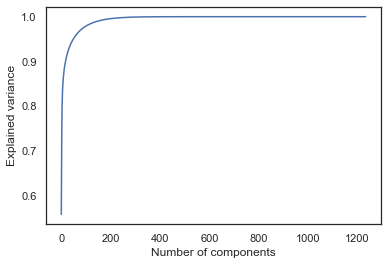

In [519]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.show()

In [520]:
# Show the variability of accuracy using the first 50 features
PCA_var_list = np.cumsum(pca.explained_variance_ratio_ * 100)
PCA_var_list[0:50]

array([55.71510541, 67.08004713, 74.26759149, 79.4605441 , 81.92748698,
       83.51878345, 84.59642901, 85.48672127, 86.23902034, 86.81952462,
       87.37281475, 87.851284  , 88.29084623, 88.69251625, 89.06111411,
       89.37553564, 89.68382934, 89.98219214, 90.26705523, 90.5342669 ,
       90.79244447, 91.02839124, 91.25446262, 91.46359624, 91.66492489,
       91.85675293, 92.04529159, 92.23169593, 92.40767405, 92.57950211,
       92.74063864, 92.89666099, 93.04733272, 93.19326845, 93.33494891,
       93.47260551, 93.60802845, 93.73740775, 93.86192315, 93.98088301,
       94.09921618, 94.21386457, 94.32348379, 94.43248513, 94.5394666 ,
       94.6455508 , 94.74767727, 94.84848877, 94.9434186 , 95.03602625])

In [524]:
# Select first 5 features that can show 80% variability in the data
pca_5 = PCA(n_components=5, random_state = 1)
cos_sim_pca5 = pca_5.fit_transform(cos_sim)
pca_5.explained_variance_ratio_

array([0.55715105, 0.11364942, 0.07187544, 0.05192953, 0.02466943])

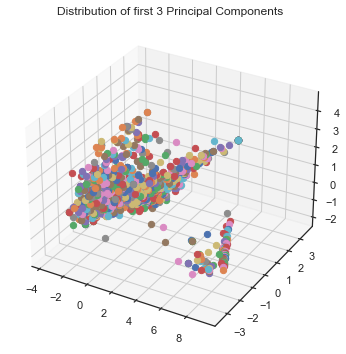

In [526]:
# Project the distribution of first 3 components
n = cos_sim_pca5.shape[0]
labels = []

ax = plt.axes(projection='3d')
for i in range(n):
    x = cos_sim_pca5[i,0]
    y = cos_sim_pca5[i,1]
    z = cos_sim_pca5[i,2]
    ax.scatter3D(x,y,z, s = 40, cmap="Blues")

plt.title("Distribution of first 3 Principal Components")   
plt.show()

### 3. Find optimal clusters using Elbow Method

In [527]:
# K-Means for Clustering
from sklearn.cluster import KMeans
X_new = cos_sim_pca5


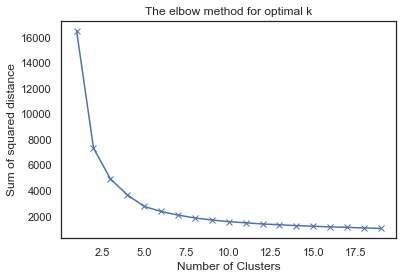

In [536]:
# Apply Elbow method and find least sum of squared distance
sum_sqr = []
plt.figure(figsize=(6,4))
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=1)
    kmeans.fit(X_new)
    sum_sqr.append(kmeans.inertia_)
    
plt.plot(range(1,20), sum_sqr, marker = "x")
plt.title("The elbow method for optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared distance")
plt.show()

### 4. Apply K-Means with 5 clusters

In [529]:
# K-Means for Clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)

In [530]:
X_new = cos_sim_pca5
kmeans.fit(X_new)
print(kmeans.cluster_centers_)
print(kmeans.labels_)

[[-0.40517843  0.94149617 -0.49842914 -0.34808093  0.107826  ]
 [ 2.73585558  2.61552365  1.02858288  1.11886963 -0.14063493]
 [ 8.15588615 -1.84625291 -0.47286372 -0.24800112  0.0287766 ]
 [-1.15718323 -0.6348618   2.09064276 -0.95976152 -0.16225345]
 [-2.08386597 -0.92484183 -0.27861412  0.56423645 -0.04205104]]
[0 4 3 ... 0 0 0]


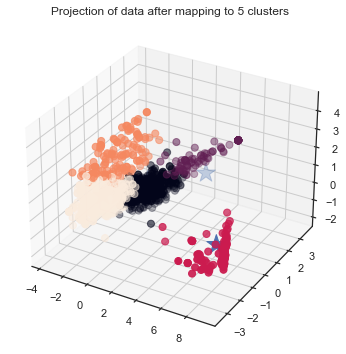

In [531]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
c_centres = kmeans.cluster_centers_
ax.scatter3D(X_new[:,0], X_new[:,1],X_new[:,2], s=50, c = kmeans.labels_)
ax.scatter(c_centres[:,0], c_centres[:,1], marker="*", c= "b", s=400)
plt.title("Projection of data after mapping to 5 clusters")
plt.show()

### 5. Concatenate all Features create input and output

In [489]:
df_tfidf = pd.concat([df, tfidfwordVector_df], axis = 1)

In [538]:
print(tfidfwordVector_df.shape)
print(df.shape)
print(df_tfidf.shape)

(1234, 500)
(1234, 9)
(1234, 512)


In [539]:
df_tfidf.head(2)

,Search Title,Job Title,Company,Location,Job Description,Years,Min_Years,Max_Years,Company_name,Main_content,...,work independently,work life,work team,working knowledge,world class,written communication,written verbal,year experience,year relevant,title_encoded
0,Data Analyst,Data Quality Analyst,Mackenzie Health On-site,"Vaughan, ON",Posted by\n\nMelany Shapiro\n\n--\n\nSend InMa...,ast 3 years,0,3,mackenzie,mackenzie health ’ s hospital — mackenzie rich...,...,0.0,0.0,0.0,0.0,0.0,0.121262,0.000000,0.290907,0.0,1
1,Data Analyst,"Sr. Data Marketing Analyst, Enterprise Analyti...",JLL Technologies,"Toronto, ON",About JLL –\n\nWe’re JLL—a leading professiona...,3 - 5 years,5,5,jll,"operation 80 country workforce 91,000 individu...",...,0.0,0.0,0.0,0.0,0.0,0.000000,0.142309,0.000000,0.0,1


In [540]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [541]:
df_tfidf['title_encoded'] = le.fit_transform(df_tfidf['Search Title'])

In [495]:
df_tfidf['title_encoded'].unique()

array([1, 4, 3, 6, 5, 2, 0])

In [496]:
le.classes_

array(['Business Analyst', 'Data Analyst', 'Data Architect',
       'Data Engineer', 'Data Scientist', 'Database Administrator',
       'Machine Learning Engineer'], dtype=object)

In [497]:
df_tfidf.head(2)

,Search Title,Job Title,Company,Location,Job Description,Years,Min_Years,Max_Years,Company_name,Main_content,...,work independently,work life,work team,working knowledge,world class,written communication,written verbal,year experience,year relevant,title_encoded
0,Data Analyst,Data Quality Analyst,Mackenzie Health On-site,"Vaughan, ON",Posted by\n\nMelany Shapiro\n\n--\n\nSend InMa...,ast 3 years,0,3,mackenzie,mackenzie health ’ s hospital — mackenzie rich...,...,0.0,0.0,0.0,0.0,0.0,0.121262,0.000000,0.290907,0.0,1
1,Data Analyst,"Sr. Data Marketing Analyst, Enterprise Analyti...",JLL Technologies,"Toronto, ON",About JLL –\n\nWe’re JLL—a leading professiona...,3 - 5 years,5,5,jll,"operation 80 country workforce 91,000 individu...",...,0.0,0.0,0.0,0.0,0.0,0.000000,0.142309,0.000000,0.0,1


In [498]:
df_tfidf.shape

(1234, 512)

### 6. Implement Random Forest Algorithm for prediction

In [662]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score,confusion_matrix, precision_score, recall_score,roc_curve, auc, classification_report

In [681]:
# Select only numeric values to be fit into the model
num_cols = list(df_tfidf.select_dtypes(include=[np.number]).columns.values)
len(num_cols)
df_model = df_tfidf.select_dtypes(include=[np.number])

In [682]:
df_model.shape

(1234, 503)

In [683]:
del df_model['Min_Years']
del df_model['Max_Years']

In [684]:
# Extract the labels
labels = np.array(df_model.pop('title_encoded'))

In [685]:
# 20% examples in test data

RSEED = 50
train, test, train_labels, test_labels = train_test_split(df_model,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.2, 
                                         random_state = RSEED)

In [686]:
print(train.shape)
print(test.shape)
print(train_labels.shape)
print(test_labels.shape)

(987, 500)
(247, 500)
(987,)
(247,)


In [687]:
features = list(train.columns)

In [688]:
# Create the model with 100 trees
model = RandomForestClassifier( n_estimators=100, random_state=RSEED, max_features = 'sqrt', n_jobs=-1, verbose = 1)

In [689]:
# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=50,
                       verbose=1)

In [690]:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 437
Average maximum depth 29


In [691]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]
print(classification_report(train_labels, train_rf_predictions))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.99      0.98      0.98       181
           1       0.97      0.96      0.97       121
           2       0.97      0.96      0.97       134
           3       0.93      0.95      0.94       121
           4       0.95      0.94      0.94        82
           5       0.97      0.98      0.98       225
           6       0.94      0.96      0.95       123

    accuracy                           0.97       987
   macro avg       0.96      0.96      0.96       987
weighted avg       0.97      0.97      0.97       987



In [692]:
# Testing predictions (to determine performance)
rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]
print(classification_report(test_labels, rf_predictions))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83        46
           1       0.70      0.70      0.70        30
           2       0.72      0.53      0.61        34
           3       0.59      0.73      0.66        30
           4       0.64      0.45      0.53        20
           5       0.74      0.86      0.79        56
           6       0.65      0.48      0.56        31

    accuracy                           0.70       247
   macro avg       0.69      0.66      0.67       247
weighted avg       0.70      0.70      0.70       247



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [693]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, train, train_labels, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.705 (0.051)


### 7. Understanding the feature importances and their role in model accuracy

In [694]:
feature_list = train.columns.to_list()
# feature_list

In [695]:
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: business             Importance: 0.03
Variable: data                 Importance: 0.03
Variable: analyst              Importance: 0.02
Variable: machine              Importance: 0.02
Variable: business analyst     Importance: 0.02
Variable: data analyst         Importance: 0.02
Variable: analysis             Importance: 0.01
Variable: analytics            Importance: 0.01
Variable: architect            Importance: 0.01
Variable: architecture         Importance: 0.01
Variable: database             Importance: 0.01
Variable: development          Importance: 0.01
Variable: engineer             Importance: 0.01
Variable: experience           Importance: 0.01
Variable: insight              Importance: 0.01
Variable: learning             Importance: 0.01
Variable: model                Importance: 0.01
Variable: pipeline             Importance: 0.01
Variable: platform             Importance: 0.01
Variable: process              Importance: 0.01
Variable: product              Importanc

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

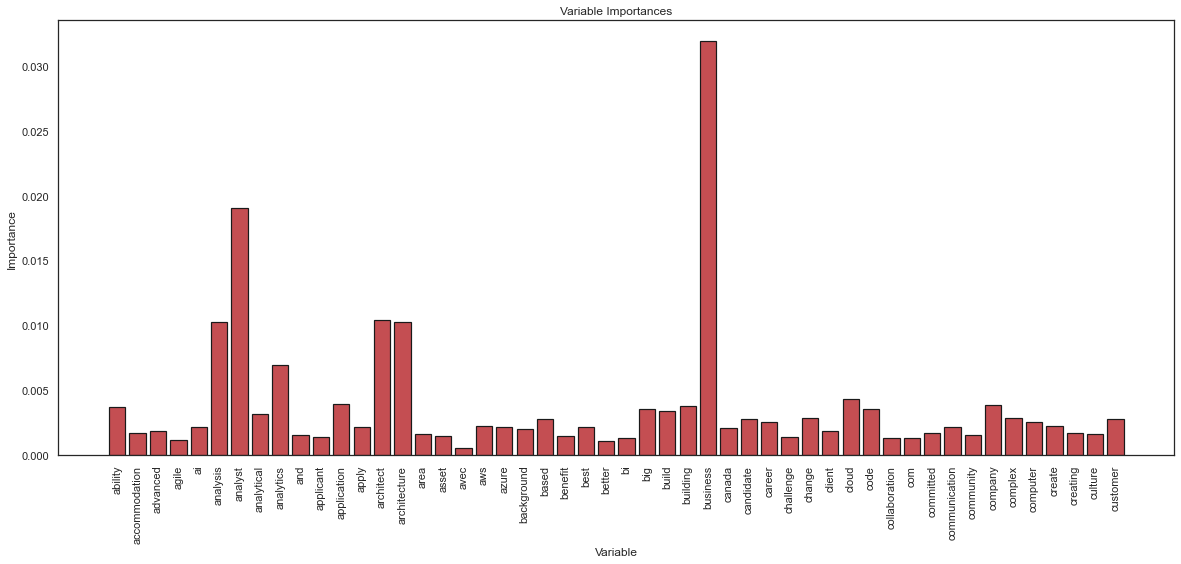

In [697]:
# View the importance of first 50 columns of the data
plt.figure(figsize=(20,8))
# list of x locations for plotting
x_values = list(range(len(importances[0:50])))
# Make a bar chart
plt.bar(x_values, importances[0:50], orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list[0:50], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

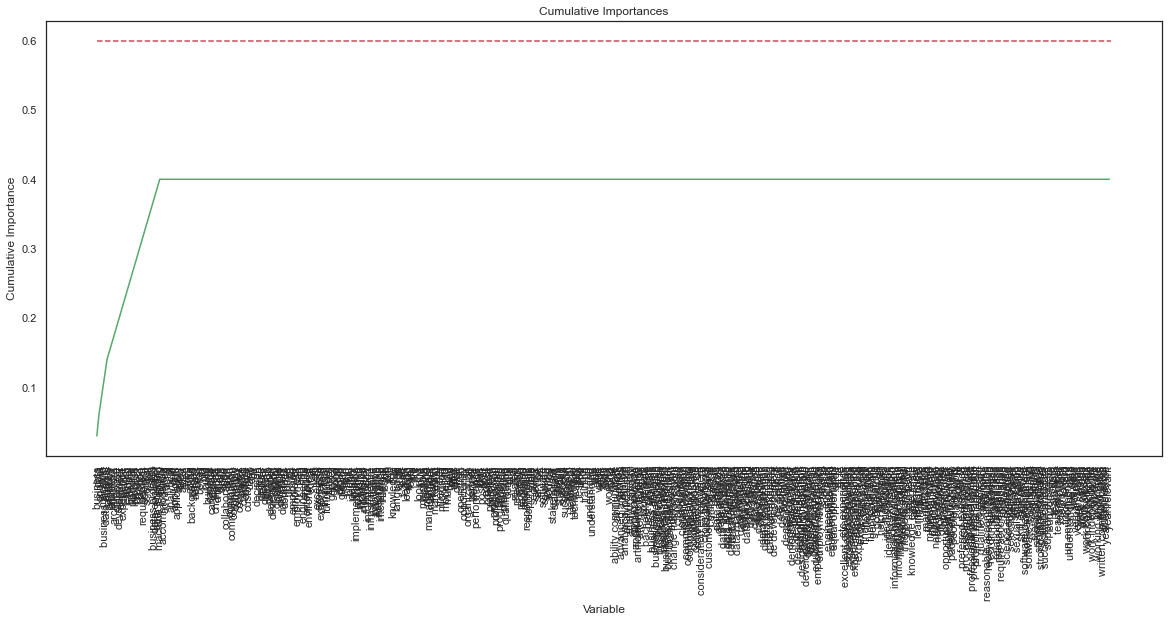

In [702]:
plt.figure(figsize=(20,8))
x_values = list(range(len(importances)))
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 60% of importance retained
plt.hlines(y = 0.6, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [706]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 40% importance:', np.where(cumulative_importances > 0.40)[0][0] + 1)


Number of features for 40% importance: 32


In [707]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:40]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important_train_features = train.iloc[:, important_indices]
important_test_features = test.iloc[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)


Important train features shape: (987, 40)
Important test features shape: (247, 40)


In [708]:
important_feature_names

['business',
 'data',
 'analyst',
 'machine',
 'business analyst',
 'data analyst',
 'analysis',
 'analytics',
 'architect',
 'architecture',
 'database',
 'development',
 'engineer',
 'experience',
 'insight',
 'learning',
 'model',
 'pipeline',
 'platform',
 'process',
 'product',
 'project',
 'python',
 'requirement',
 'science',
 'scientist',
 'skill',
 'team',
 'business process',
 'data engineer',
 'data scientist',
 'machine learning',
 'ability',
 'accommodation',
 'advanced',
 'agile',
 'ai',
 'analytical',
 'and',
 'applicant']

In [709]:
important_feature_names.index('python')

22

In [710]:
feature_list = train.columns.to_list()

In [711]:
train.iloc[:, important_indices]

,business,data,analyst,machine,business analyst,data analyst,analysis,analytics,architect,architecture,...,data scientist,machine learning,ability,accommodation,advanced,agile,ai,analytical,and,applicant
865,0.156668,0.780681,0.000000,0.000000,0.000000,0.0,0.091368,0.170357,0.099333,0.111027,...,0.00000,0.000000,0.026582,0.000000,0.040751,0.039479,0.000000,0.000000,0.038198,0.000000
643,0.000000,0.165003,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.258937,0.096473,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.205822,0.000000,0.000000,0.000000,0.000000
623,0.072226,0.658198,0.000000,0.000000,0.000000,0.0,0.032761,0.146601,0.000000,0.079620,...,0.11094,0.000000,0.028594,0.000000,0.000000,0.042467,0.052701,0.038943,0.000000,0.000000
213,0.099485,0.031263,0.000000,0.147836,0.000000,0.0,0.067689,0.000000,0.000000,0.000000,...,0.00000,0.412434,0.039386,0.085115,0.000000,0.000000,0.399249,0.000000,0.028299,0.000000
323,0.097700,0.460524,0.000000,0.000000,0.000000,0.0,0.000000,0.049577,0.000000,0.053851,...,0.00000,0.000000,0.077357,0.055725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.122188,0.069114,0.000000,0.000000,0.000000,0.0,0.033254,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.116096,0.083631,0.044496,0.000000,0.000000,0.039529,0.041708,0.000000
538,0.100416,0.000000,0.054538,0.000000,0.131893,0.0,0.045548,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.039754,0.057275,0.000000,0.000000,0.000000,0.054142,0.000000,0.000000
863,0.126517,0.443010,0.000000,0.000000,0.000000,0.0,0.000000,0.082543,0.120325,0.119546,...,0.00000,0.000000,0.021466,0.030927,0.000000,0.000000,0.276946,0.029235,0.000000,0.000000
1020,0.158088,0.029807,0.000000,0.000000,0.000000,0.0,0.086049,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.112655,0.000000,0.000000,0.000000,0.000000,0.051143,0.000000,0.057326


In [712]:
# Train the expanded model on only the important features
model.fit(important_train_features, train_labels);
# Make predictions on test data
predictions = model.predict(important_test_features)
print(classification_report(test_labels, predictions))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

           0       0.87      0.87      0.87        46
           1       0.66      0.77      0.71        30
           2       0.68      0.62      0.65        34
           3       0.59      0.67      0.62        30
           4       0.62      0.50      0.56        20
           5       0.79      0.88      0.83        56
           6       0.65      0.48      0.56        31

    accuracy                           0.72       247
   macro avg       0.69      0.68      0.68       247
weighted avg       0.72      0.72      0.72       247



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [713]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, important_train_features, train_labels, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.706 (0.050)


### 8. Using GridSearch to tune hyper parameters for maximum accuracy

In [714]:
from sklearn.ensemble import RandomForestClassifier
print(RandomForestClassifier())

RandomForestClassifier()


In [715]:
rfc = RandomForestClassifier()
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]
    
}

In [716]:
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rfc,parameters,cv=5)
cv.fit(train,train_labels)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 8, 16, 32, None],
                         'n_estimators': [5, 10, 50, 100, 250]})

In [717]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [718]:
display(cv)

Best parameters are: {'max_depth': None, 'n_estimators': 250}


0.426 + or -0.015 for the {'max_depth': 2, 'n_estimators': 5}
0.513 + or -0.062 for the {'max_depth': 2, 'n_estimators': 10}
0.503 + or -0.035 for the {'max_depth': 2, 'n_estimators': 50}
0.527 + or -0.047 for the {'max_depth': 2, 'n_estimators': 100}
0.529 + or -0.041 for the {'max_depth': 2, 'n_estimators': 250}
0.549 + or -0.031 for the {'max_depth': 4, 'n_estimators': 5}
0.582 + or -0.047 for the {'max_depth': 4, 'n_estimators': 10}
0.631 + or -0.05 for the {'max_depth': 4, 'n_estimators': 50}
0.634 + or -0.055 for the {'max_depth': 4, 'n_estimators': 100}
0.657 + or -0.064 for the {'max_depth': 4, 'n_estimators': 250}
0.575 + or -0.032 for the {'max_depth': 8, 'n_estimators': 5}
0.648 + or -0.036 for the {'max_depth': 8, 'n_estimators': 10}
0.677 + or -0.051 for the {'max_depth': 8, 'n_estimators': 50}
0.69 + or -0.049 for the {'max_depth': 8, 'n_estimators': 100}
0.7 + or -0.052 for the {'max_depth': 8, 'n_estimators

In [720]:
Tunedmodel = RandomForestClassifier(n_estimators=250, random_state=RSEED, max_features = 'sqrt', 
                                    n_jobs=-1, verbose = 1, max_depth=None)

In [722]:
# Train the expanded model on only the important features
Tunedmodel.fit(important_train_features, train_labels);
# Make predictions on test data
predictions = Tunedmodel.predict(important_test_features)
print(classification_report(test_labels, predictions))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s


              precision    recall  f1-score   support

           0       0.89      0.87      0.88        46
           1       0.67      0.73      0.70        30
           2       0.71      0.65      0.68        34
           3       0.54      0.67      0.60        30
           4       0.59      0.50      0.54        20
           5       0.78      0.89      0.83        56
           6       0.65      0.42      0.51        31

    accuracy                           0.72       247
   macro avg       0.69      0.68      0.68       247
weighted avg       0.72      0.72      0.71       247



[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.0s finished


In [724]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(Tunedmodel, important_train_features, train_labels, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.704 (0.048)


In [726]:
conf_mtx = confusion_matrix(test_labels,predictions)
conf_mtx

array([[40,  5,  0,  0,  0,  1,  0],
       [ 0, 22,  4,  2,  1,  1,  0],
       [ 0,  1, 22,  6,  3,  1,  1],
       [ 0,  2,  3, 20,  0,  3,  2],
       [ 1,  1,  1,  1, 10,  2,  4],
       [ 3,  1,  0,  1,  1, 50,  0],
       [ 1,  1,  1,  7,  2,  6, 13]], dtype=int64)

Text(0.5, 48.5, "{'Data Analyst', 'Database Administrator', 'Data Architect', 'Business Analyst', 'Data Scientist', 'Data Engineer', 'Machine Learning Engineer'}")

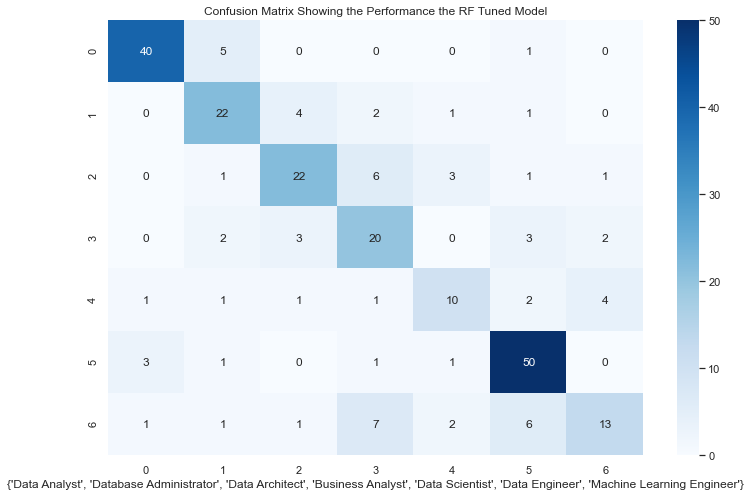

In [736]:
plt.figure(figsize=(12,8))

sns.heatmap(conf_mtx, annot = True, cmap="Blues" )
plt.title("Confusion Matrix Showing the Performance the RF Tuned Model")
plt.xlabel(set(le.classes_))
